# CDMFT and the Mott transition in graphene

- Construct a model file (python) that describes graphene, based on a single, two-site cluster with a bath of 4 sites, similar to the one used for the one-dimensional Hubbard model done in the examples provided with the pyqcm distribution.
Check that the correct dispersion relation is found at $U=0$ by plotting the spectral function.
- At half filling, find de CDMFT solution (normal state) as a function of $U$, from $U=10$ to $U=0$ in steps of $\Delta U=0.2$. Can you identify the Mott transition? Stay at half-filling, using particle-hole symmetry.

In [1]:
from pyqcm import *
# from scipy import *
from pyqcm.spectral import *
from pyqcm.cdmft import *
from pyqcm.loop import controlled_loop
import numpy as np
from pyqcm.draw_operator import *
import os

import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 150

Number of openMP threads = 4


In [2]:
# set_global_parameter("potential_energy")

In [3]:
# Constructing a new cluster model
ns = 2 # number of physical sites
nb = 4 # number of bath sites
no = ns+nb # total number of sites
new_cluster_model('clus', ns, nb)

### Geometry used to model graphene

For the lattice to be a Bravais lattice, we can, for example, pair the adjacent carbons two-by-two which will result in a scissorgrid Bravais lattice. In this case, since we are running a CDMFT procedure, we need to define 4 *bath* orbitals around the 2 site cluster and pair them up as to represent the presence of neighbouring clusters. 

The hopping operators to and from the bath sites are the "tb1" and "tb2" operators while the respective energy level of the orbitals are "eb1" and "eb2".

In [4]:
# Defining the bath hopping operators
new_cluster_operator('clus', 'tb1', 'one-body', [
    (1, 3, -1.0),
    (2, 4, -1.0),
    (1+no, 3+no, -1.0),
    (2+no, 4+no, -1.0)
]) # note that the last two entries pertain to the SPIN DOWN part of the operator

new_cluster_operator('clus', 'tb2', 'one-body', [
    (1, 5, -1.0),
    (2, 6, -1.0),
    (1+no, 5+no, -1.0),
    (2+no, 6+no, -1.0)
])

# Defining the 'orbital energy' of the baths
new_cluster_operator('clus', 'eb1', 'one-body', [
    (3, 3, 1.0),
    (4, 4, 1.0),
    (3+no, 3+no, 1.0),
    (4+no, 4+no, 1.0)
])

new_cluster_operator('clus', 'eb2', 'one-body', [
    (5, 5, 1.0),
    (6, 6, 1.0),
    (5+no, 5+no, 1.0),
    (6+no, 6+no, 1.0)
])

In [5]:
add_cluster('clus', [0,0,0], [[0,0,0], [1,0,0]]) # Adding the cluster in
lattice_model('Graphene_2', [[1,-1,0], [2,1,0]], [[1,-1,0], [2,1,0]]) # Tiling like an old scissorgrid elevator
set_basis([[1,0,0],[-0.5,np.sqrt(3)/2,0]]) # Classic Graphene basis (for simplicity and graphical purposes)

In [6]:
# Defining the interaction operator on BOTH bands
interaction_operator('U', band1=1, band2=1)
interaction_operator('U', band1=2, band2=2)

# Defining NN hopping terms
hopping_operator('t', [1,0,0], -1, band1=1, band2=2) # All hops here are from one band to another
hopping_operator('t', [0,1,0], -1, band1=1, band2=2)
hopping_operator('t', [-1,-1,0], -1, band1=1, band2=2)

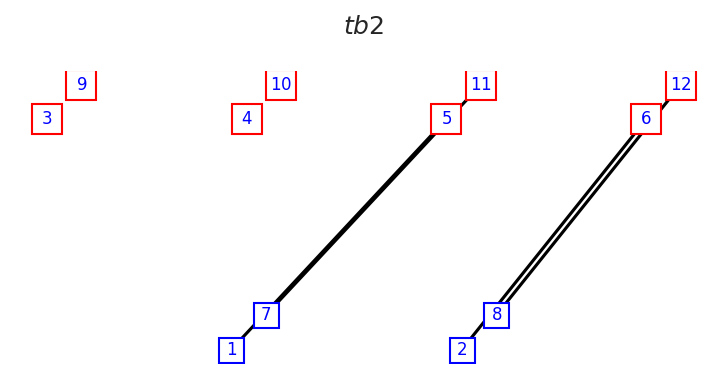

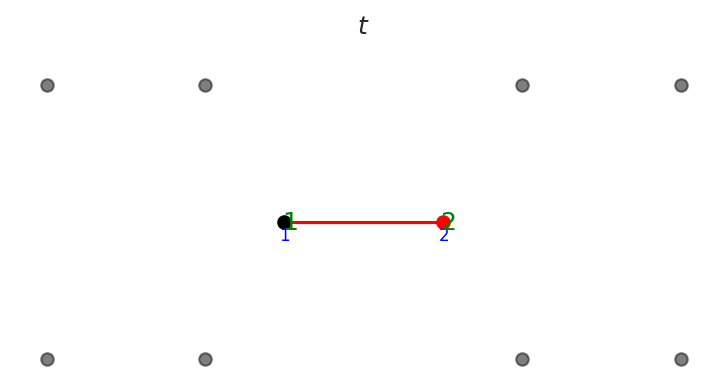

In [7]:
draw_cluster_operator('clus', 'tb2')
draw_operator('t', show_neighbors=True)

In [8]:
# Imposing half-filling at 6 particles in cluster + bath sites and setting total spin to 0
set_target_sectors(['R0:N6:S0'])

# Simulation parameters
set_parameters("""
    U=4
    mu=0.5*U
    t=1
    tb1_1=0.5
    tb2_1=1*tb1_1
    eb1_1=1.0
    eb2_1=-1.0*eb1_1
""")

[('U', 4.0),
 ('mu', 0.5, 'U'),
 ('t', 1.0),
 ('tb1_1', 0.5),
 ('tb2_1', 1.0, 'tb1_1'),
 ('eb1_1', 1.0),
 ('eb2_1', -1.0, 'eb1_1')]

### Spectral function of graphene (U=0)
As can be seen below, the typical graphene spectral function is obtained. 

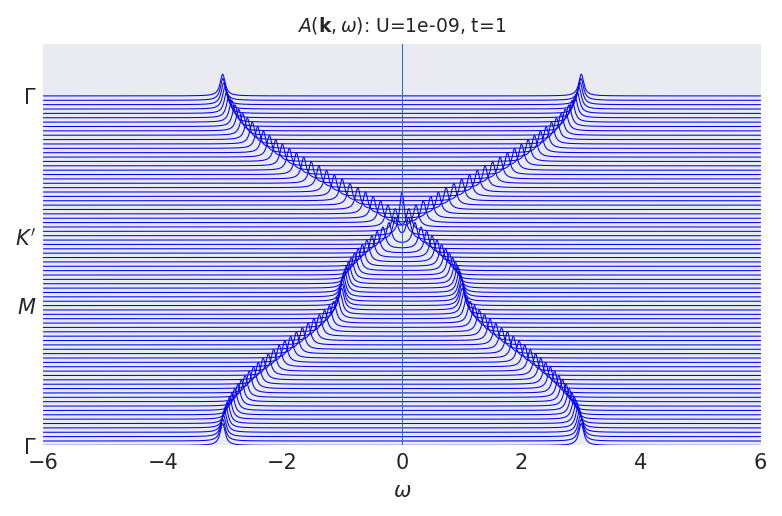

In [9]:
# Setting a trivially small interaction value
set_parameter("U", 1e-9)
new_model_instance()

# Plotting the spectral function, both bands are identical
spectral_function(path="graphene", band=1) # Using the built-in graphene path is recommended here

In [10]:
# Setting up the range of values of U over which to loop the CDMFT simulation 
U_start = 0.2 # starting at U=0.2 because the nearly non-interacting case is too long to calculate
U_stop = 10.1
U_step = 0.2

In [11]:
# Removes the default output file for display purposes
if os.path.isfile("./cdmft.tsv"):
    os.remove("./cdmft.tsv")

In [12]:
# Defining a function that will run a cdmft procedure within controlled_loop()

def run_cdmft():
    U = parameters()['U']
    cdmft(varia=["tb1_1", "eb1_1"], wc=10, grid_type='self', beta=50) # setting the bath operators as the variationnal parameters

# Looping over values of U
controlled_loop(
    func=run_cdmft, 
    varia=["tb1_1", "eb1_1"], 
    loop_param="U", 
    loop_range=(U_start, U_stop, U_step)
    )


%%%%%%%%%%%%%%%%%%%%%%%%%%%% controlled loop over U %%%%%%%%%%%%%%%%%%%%%%%%%%%%


========================== loop index = 1, U = 0.2000 ==========================


******************************* CDMFT procedure *******************************

minimization method =  CG
mixing state =  0
frequency grid type =  self
fictitious inverse temperature =  50
frequency cutoff =  10
--------------------------------------------------------------------------------

CDMFT iteration 1, distance =  5.14e-01, diff param =  4.16e-01
8 minimization steps, time(MIN)/time(ED)=1.17047
tb1_1     =  0.8783	eb1_1     =  0.5501	

CDMFT iteration 2, distance =  1.55e-01, diff param =  6.75e-02, diff hybrid =  8.47e-02
5 minimization steps, time(MIN)/time(ED)=0.59143
tb1_1     =  0.9189	eb1_1     =  0.6365	

CDMFT iteration 3, distance =  1.74e-01, diff param =  7.52e-03, diff hybrid =  8.10e-03
2 minimization steps, time(MIN)/time(ED)=0.39800
tb1_1     =  0.9166	eb1_1     =  0.6262	

CDMFT iteration 4, dist

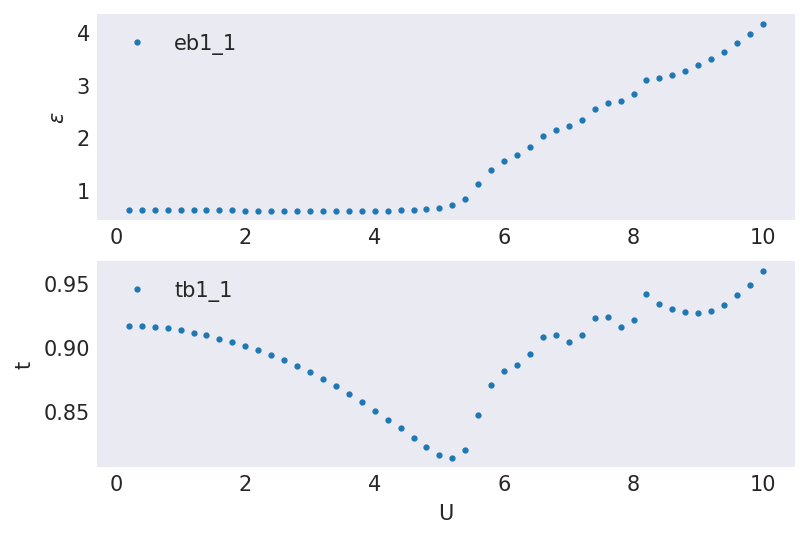

In [13]:
cdmft_data = np.genfromtxt("cdmft.tsv", delimiter="\t", names=True)

# plotting both orbital energies and site<-->bath hopping operator amplitude
ax1 = plt.subplot(211)
ax1.plot(cdmft_data['U'], cdmft_data['eb1_1'], "o", markersize=2, label="eb1_1")

ax1.set_ylabel("$\epsilon$")

ax1.legend()

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(cdmft_data['U'], cdmft_data['tb1_1'], "o", markersize=2, label="tb1_1")

ax2.set_xlabel("U")
ax2.set_ylabel("t")

ax2.legend()

plt.show()

### Interpretation and Mott transition

From the above plots, we can see how the orbital energies and the hopping operators defined for the bath sites seem to change drastically as to indicate a Mott transition at $U\approx5$. By plotting the spectral function for $U$ values of 4, 5 and 6, we can see how this transition effects the spectral gap. 

19
reading data file cdmft.tsv, line 20
30 columns read
----->  U  =  4.0
----->  eb1_1  =  0.61431543
----->  t  =  1.0
----->  tb1_1  =  0.84964446


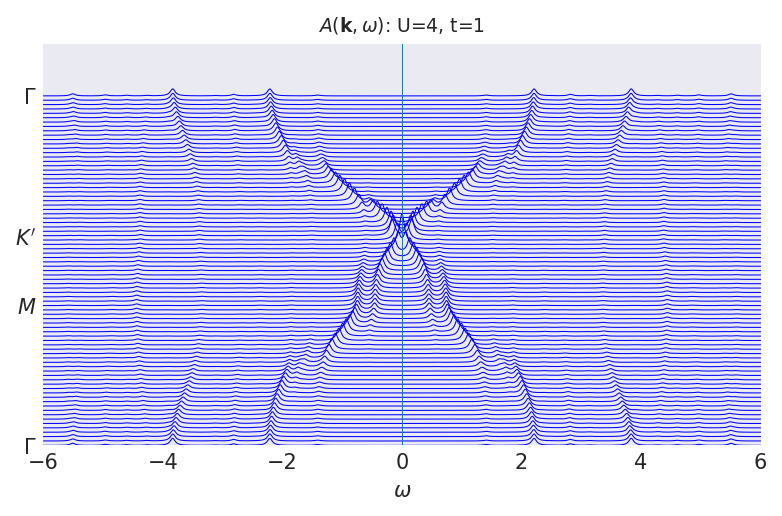

reading data file cdmft.tsv, line 25
30 columns read
----->  U  =  5.0
----->  eb1_1  =  0.67723267
----->  t  =  1.0
----->  tb1_1  =  0.81535624


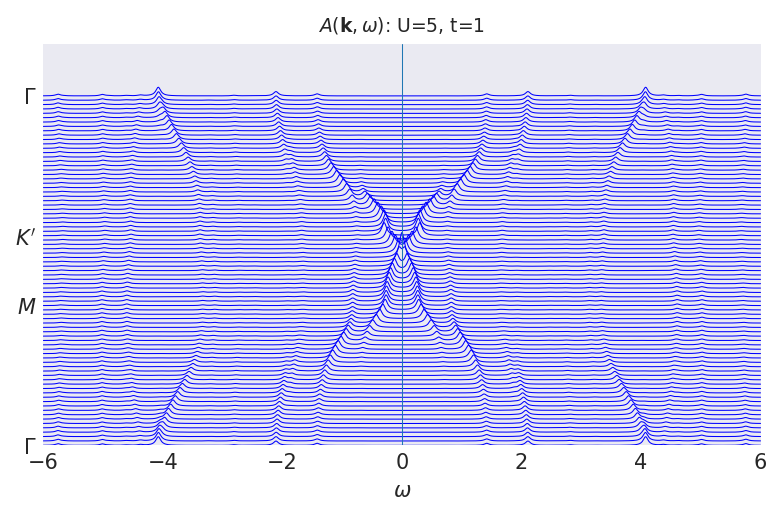

reading data file cdmft.tsv, line 30
30 columns read
----->  U  =  6.0
----->  eb1_1  =  1.553938
----->  t  =  1.0
----->  tb1_1  =  0.88153076


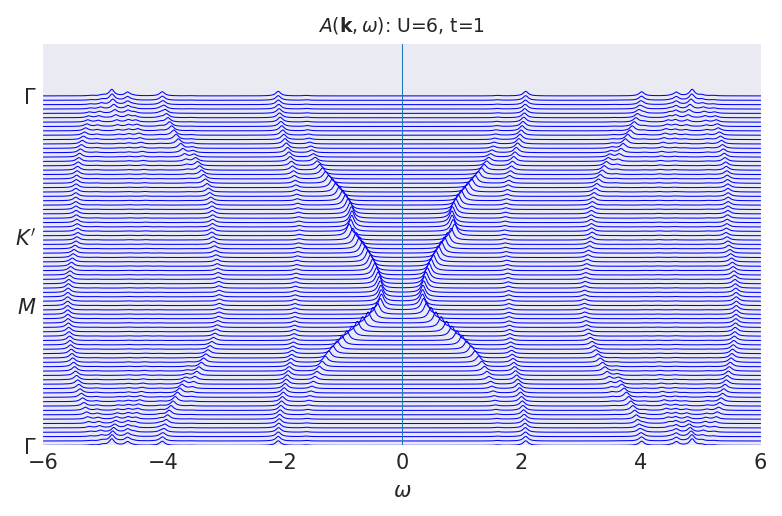

In [14]:
index_of_U = np.where(cdmft_data['U'] == 4)[0][0] # Finding the index at which U=4
print(index_of_U)
set_params_from_file('cdmft.tsv', n=index_of_U)
new_model_instance()
spectral_function(path="graphene", band=1) 

index_of_U = np.where(cdmft_data['U'] == 5)[0][0] # Finding the index at which U=4
set_params_from_file('cdmft.tsv', n=index_of_U)
new_model_instance()
spectral_function(path="graphene", band=1) 

index_of_U = np.where(cdmft_data['U'] == 6)[0][0] # Finding the index at which U=4
set_params_from_file('cdmft.tsv', n=index_of_U)
new_model_instance()
spectral_function(path="graphene", band=1) 